# Non-Cartesian T1 | Subspace-Constrained Reconstruction
This tutorial uses the [`BART`](http://mrirecon.github.io/bart/) command-line interface (CLI) and presents how to work with radial data using BART, with the goal of implementing a full processing pipeline from raw data to T1 maps.


## Outline
1. Bart Setup
2. Simulation IR radial FLASH
5. Prepare Subspace Reconstruction
   1. Subspace basis generation
    6. Subspace reconstruction
    7. Postprocessing
6. Reconstruction Pulseq Data
   1. Prepare data
   2. Subspace reconstruction
   3. Postprocessing
   


**Author**: [Vitali Telezki](mailto:vitali.telezki@med.uni-goettingen.de)

**Institution**: University Medical Center Göttingen

Based on previous material written by [Daniel Mackner](mailto:daniel.mackner@tugraz.at), [Moritz Blumenthal](mailto:blumenthal@@tugraz.at) and [Jon Tamir](mailto:jtamir@utexas.edu).

In this interactive session, we recommend running BART calls in the terminal, and use this notebook as a reference. Nevertheless, we will provide some examples of how to run BART commands in this notebook to be self-contained.

**💡CAVE:💡**

- **`%%bash` Cells in Jupyter Notebooks:**
  Magic commands like `%%bash` allow you to run bash commands directly within your notebook.
  Simply prefix your cell with `%%bash`, and you can run any shell command, including calls to BART tools, just as you would in a terminal.

- **`%%pybash` Cells in this Jupyter Notebook:**
   Since it is cumbersome to redefine bash variables over and over, we use a custom magic command `%%pybash` instead. This custom magic command allows to access python variables inside the `bash` environment, making execution more convenient and consistent. The caveat here is that variables need to be enclosed by `{}` and not preceeded by `$`. Be careful, when copy-pasting code to your terminal. We use `%%bash` wherever possible for simple translation. 

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# import os
import src.plotSubspace as ps
# import numpy as np
# import importlib

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['ggplot', 'src/customStyle.mplstyle'])

In [2]:
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

ipython = get_ipython()


@register_cell_magic
def pybash(line, cell):
    ipython.run_cell_magic('bash', '', cell.format(**globals()))

## Bart Setup Check


In [3]:
%%bash
echo "# BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# BART used in this notebook:
/home/vtelezki/Repos/Groups/AG_Uecker/barts/bart/bart
# BART version: 
v0.9.00-1131-g7dd53c3


## Simulation: inversion-prepared radial FLASH 
Using `bart phantom`, we will create a a numerical phantom with the inversion-prepared radial FLASH sequence with the following parameters. We use `bart signal` to simulate signal curves from individual vials and background and join them in one file

In [4]:
# Define Sequence Parameters

TR=0.006 # [s]
DIM=384 # Readouts
SPOKES=1
REP=700 # Repetitions
NC=8 # Number of Coils

BR=int(DIM/2) # Base resolution, as DIM includes two-fold oversampling

In [5]:
%%pybash
# create trajectory, account for oversampling factor 2
bart traj -o 2 -x {BR} -y {SPOKES} -t {REP} -r -G - | bart transpose 5 10 - traj
# bart scale 0.5 tmp_traj traj 

echo dimensions of trajectory
head -n2 traj.hdr

# create geometry basis functions
bart phantom -s {NC} -T -k -b -t traj tmp_basis_geom
#create phantom in plane mask 
bart phantom -x {BR} -T roi_mask

# check the dimensions
echo dimensions of geometry basis functions
head -n2 tmp_basis_geom.hdr

# create signal tubes and background
bart signal -F -I -n {REP} -r {TR}  -1 0.2:2.2:10 -2 0.045:0.045:1 tmp_basis_simu_tubes
bart signal -F -I -n {REP} -r {TR}  -1 3:3:1 -2 1:1:1 tmp_basis_simu_water

bart join 6 tmp_basis_simu_water tmp_basis_simu_tubes tmp_basis_simu
# check the dimensions
echo dimensions of signal basis functions
head -n2 tmp_basis_simu.hdr

dimensions of trajectory
# Dimensions
3 384 1 1 1 700 1 1 1 1 1 1 1 1 1 1 
dimensions of geometry basis functions
# Dimensions
1 384 1 8 1 700 11 1 1 1 1 1 1 1 1 1 
dimensions of signal basis functions
# Dimensions
1 1 1 1 1 700 11 1 1 1 1 1 1 1 1 1 


In [6]:
%%bash
# create simulated dataset
bart fmac -s $(bart bitmask 6) tmp_basis_geom tmp_basis_simu simu_ksp

# add noise to the simulated dataset 
bart noise -n1 simu_ksp simu_ksp 
# check the dimensions
echo dimensions of simulated phantom 
head -n2 simu_ksp.hdr

## remove tmp files
rm tmp_*

dimensions of simulated phantom
# Dimensions
1 384 1 8 1 700 1 1 1 1 1 1 1 1 1 1 


## Subspace Reconstruction
Now, we aim to reconstruct the simulated phantom data. First, we create a signal dictionary, then we perform a SVD and finally create the temporal basis used in subspace reconstruction.

The signal model according to Look-Locker in voxel $r$ at time $t$ is
$$ 
M(t,r)~=~M_{ss}(r)~-~\left[M_{ss}(r)~+~M_{0}(r)\right]~e^{-tR_1^*(r)}.~
$$


In [7]:
%%bash 
bart show -m simu_ksp

Type: complex float
Dimensions: 16
AoD:	1	384	1	8	1	700	1	1	1	1	1	1	1	1	1	1


### Create Signal Dictionary
Using `bart signal` we create our signal dictionary with `nR1s` values for R1star and `nMss` values for steady-state magnetization. 

In [8]:
## signal parameter
nR1s=1000
nMss=100 


In [9]:
%%pybash
bart signal -help

bart signal -F -I -n {REP} -r {TR} -1 5e-3:5:{nR1s} -3 1e-2:1:{nMss} tmp_dict
# reshape the dictionary to have all the elements on the 6th dimension
bart reshape $(bart bitmask 6 7) $(({nR1s} * {nMss})) 1 tmp_dict tmp_dict1
head -n2 tmp_dict1.hdr
# squeeze the dicc1 before SVD
bart squeeze tmp_dict1 subspace_dict
head -n2 subspace_dict.hdr
# perform SVD on dictionary
bart svd -e subspace_dict U S V

Usage: signal [-F] [-B] [-T] [-S] [-M] [-G] [-C] [-A] [--fat] [-I] [-s] [--short-TR-LL-approx] [-0 f:f:f] [-1 f:f:f] [-2 f:f:f] [-3 f:f:f] [-4 f:f:f] [-5 f:f:f] [-6 f:f:f] [-r f] [-e f] [-i f] [-f f] [-d f] [-t f] [-n d] [-b d] [--av-spokes d] [-m d] [--freq-samples d] [--pulsed] [-l f] [-a f] [--acquisition-only] <basis-functions> 

Analytical simulation tool.

-F                      FLASH
-B                      bSSFP
-T                      TSE
-S                      SE
-M                      MOLLI
-G                      MGRE
-C                      IR MGRE
-A                      ASL
--fat                   Simulate additional fat component.
-I                      inversion recovery
-s                      inversion recovery starting from steady state
--short-TR-LL-approx    Short TR approximation for analytical LL model.
-0 min:max:N            range of off-resonance frequency [Hz]
-1 min:max:N            range of T1s [s]
-2 min:max:N            range of T2s [s]
-3 min:max:N 

### Visualize simulated dictionay and PCA coeffcients

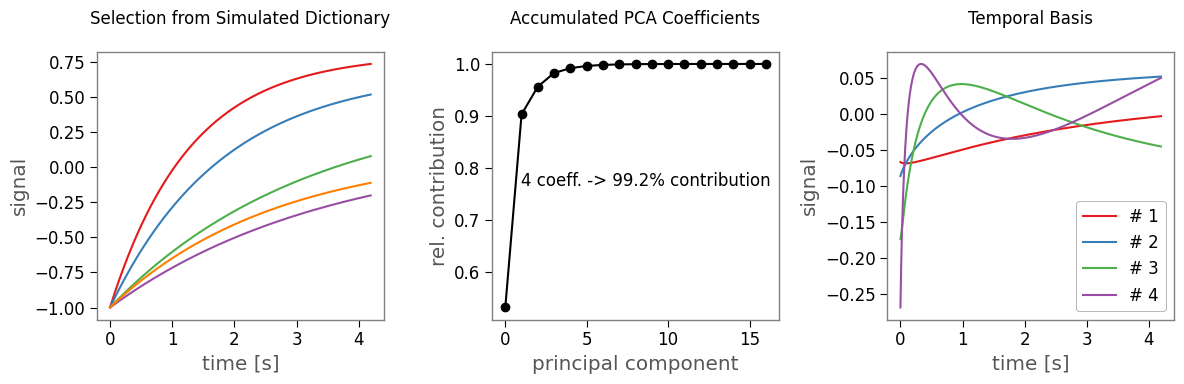

In [10]:
importlib.reload(ps)
ps.plotSubspace()


### Estimate Coil Sensitivities Using Subspace
We realized, that 4 PCA coefficients contribute to more than 99% of the observed signal. Hence, we can reduce our basis to only contain the first 4 eigenvectors. We create a subspace basis spanned by those 4 eigenvectors.


In [11]:
nCoe=4 # use 4 coefficients

In [12]:
%%pybash
# create the temporal basis
bart extract 1 0 {nCoe} U subbasis
# transpose the basis to have time on the 6th dimension and coefficients on the 5th dimension
bart transpose 1 6 subbasis - | bart transpose 0 5 - subbasis 
head -n2 subbasis.hdr

# Dimensions
1 1 1 1 1 700 4 1 1 1 1 1 1 1 1 1 



 Now, we estimate coil sensitivities using `bart ncalib` and reduced subspace basis in one go. 

In [13]:
%%bash
DEBUG_LEVEL=4 bart ncalib -N -i8 -t traj -B subbasis simu_ksp sens_ncalib

Est. image size: 192 192 1
ksp : [  1 384   1   8   1 700   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 48  48   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 700   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 384   1   8   1 700   1   1   1   1   1   1   1   1   1   1 ]
images:     [ 48  48   1   1   1   1   4   1   1   1   1   1   1   1   1   1 ]
coils:      [ 16  16   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
basis:      [  1   1   1   1   1 700   4   1   1   1   1   1   1   1   1   1 ]
mask:       [  1   1   1   1   1   1   1   1   1

### Perform reconstruction 

Using estimated coil sensitvities, we can now perform parrallel imaging reconstruction with `bart pics`.

In [14]:
ITER=100
REG=0.0005


In [15]:

%%pybash
# # reconstruction with subspace constraint
bart pics -g -e -d5 -i {ITER} -R W:$(bart bitmask 0 1):$(bart bitmask 6):{REG} -B subbasis -t traj simu_ksp sens_ncalib subspace_reco

# multiply it with the roi_mask
bart fmac roi_mask subspace_reco subspace_reco

Basis: [192 192   1   8   1 700   4   1   1   1   1   1   1   1   1   1 ]
Max:   [192 192   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
GPU reconstruction
[  1 384   1   8   1 700   4   1   1   1   1   1   1   1   1   1 ]
[192 192   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384   1   8   1 700   4   1   1   1   1   1   1   1   1   1 ]
cim : [192 192   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 700   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
psf_dims: [192 192   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [384 384   1   1   1   1  16   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1   1 ]
wgh :

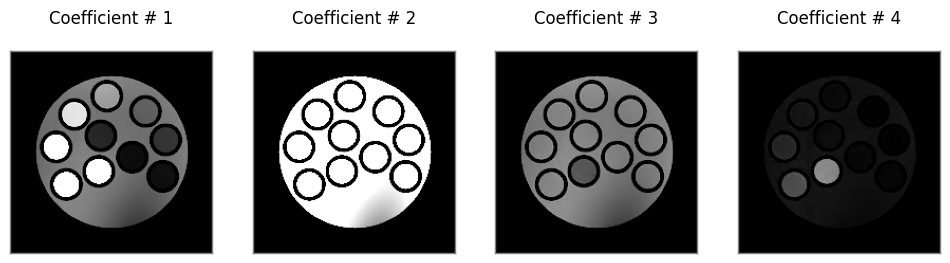

In [16]:
importlib.reload(ps)
ps.plotCoefficientMaps()

### Temporal Signal Evolution

In [17]:
%%bash 
bart fmac -s $(bart bitmask 6) subbasis subspace_reco imgs

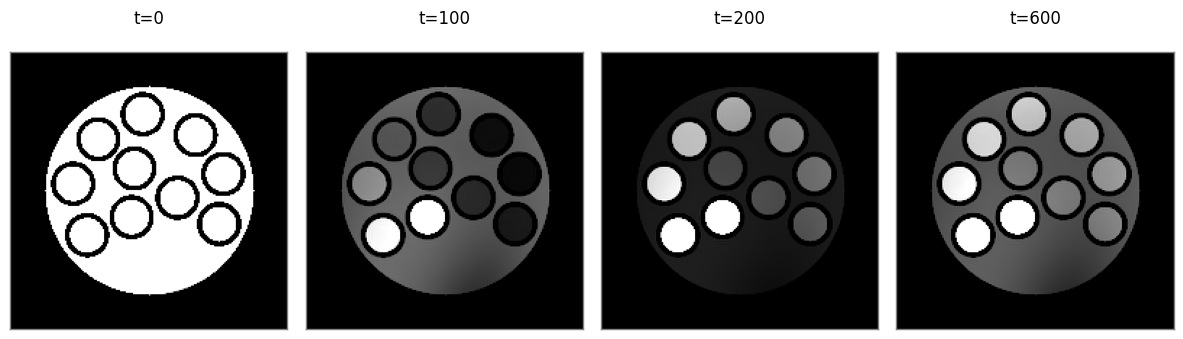

In [18]:
importlib.reload(ps)
ps.plotTemporalEvolution()


### T1 Map from Reconstructed Images
Using `bart mobafit` we obtain T1 parameter map via pixel-wise fitting. 

In [19]:
%%pybash

### create vector with inversion times nREP*TR
bart index 5 {REP} - | bart scale {TR} - TI

bart mobafit -g -B subbasis -L --init 1:1:1 TI subspace_reco - | bart looklocker -t0 - -| bart fmac roi_mask - t1map

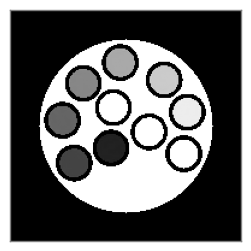

In [20]:
ps.plotT1Map()

## Reconstruction Pulseq Data

Now, that we are familiar with subspace reconstruction, we apply this method on real-world data. In this case, we aim to reconstruct data obtained with Pulseq and a sequence prepared by `bart seq`.

### Convert dat file to cfl
First, we need to convert Siemens `.dat` file to bart `.cfl/.hdr` file format using `bart twixread` and check input file dimensions.

In [21]:
%%bash 
bart twixread -A -r 1 data/meas_MID00019 tmp_ksp
head -n2 tmp_ksp.hdr

VD/VE Header. MeasID: 19 FileID: 67798 Scans: 1
Patient: xxxxxxxxxxxxx
Protocol: pulseq
VD/VE Header. MeasID: 19 FileID: 67798 Scans: 1
Patient: xxxxxxxxxxxxx
Protocol: pulseq


# Dimensions
1 512 1131 18 1 1 1 1 1 1 1 1 1 1 1 1 


We notice `PHS2_DIM` should be `TE_DM` instead.

In [22]:
%%bash 
bart transpose 2 5 tmp_ksp tmp_ksp
head -n2 tmp_ksp.hdr

# Dimensions
1 512 1 18 1 1131 1 1 1 1 1 1 1 1 1 1 


### Trajectory and Sequence Params
You should have all relevant information from initial use of `bart seq`, when preparing Pulseq sequence. In case that is lost, we rerun the following commands. 

In [23]:
FIBO=377  # fibonacci number satisfying Nyquist when using RAGA
FRAMES=3
REP=int(FIBO*FRAMES)

In [24]:
%%pybash 

bart seq --IR_NON --raga -t {REP} -r {FIBO} grad mom adc
bart vec 1 1 0 tmp_a
bart extract 0 2 5 adc - | bart fmac - tmp_a traj
bart scale 0.5 traj traj
head -n2 traj.hdr

loops: 3837483 	 dims: [  1 377   1   1   1   1   3   3 377   1   3   1   1   1   1   1 ]
kernels: 1131 	 dims: [  1 377   1   1   1   1   1   1   1   1   3   1   1   1   1   1 ]
Nr. of RF shapes: 2


# Dimensions
3 512 377 1 1 1 1 1 1 1 3 1 1 1 1 1 


For subspace reco, all spokes in dim 5:

In [25]:
%%pybash 
bart reshape $(bart bitmask 2 10) 1 {REP} traj - | bart transpose 5 10 - traj
head -n2 traj.hdr

# Dimensions
3 512 1 1 1 1131 1 1 1 1 1 1 1 1 1 1 


### Parameter for Dictionary

In [26]:
TR=0.00311 # [s] , BlockDurationRaster x DUR = 1e-05 x 311 = 0.00311
nR1s=1000
nMss=100

In [27]:
%%pybash
### create vector with inversion times nREP*TR
bart index 5 {REP} - | bart scale {TR} - TI
bart signal -F -I -n {REP} -r {TR} -1 5e-3:5:{nR1s} -3 1e-2:1:{nMss} tmp_dict
# reshape the dictionary to have all the elements on the 6th dimension
bart reshape $(bart bitmask 6 7) $(({nR1s} * {nMss})) 1 tmp_dict tmp_dict1
head -n2 tmp_dict1.hdr
# squeeze the dicc1 before SVD
bart squeeze tmp_dict1 subspace_dict
head -n2 subspace_dict.hdr
# perform SVD on dictionary
bart svd -e subspace_dict U S V

# Dimensions
1 1 1 1 1 1131 100000 1 1 1 1 1 1 1 1 1 
# Dimensions
1131 100000 


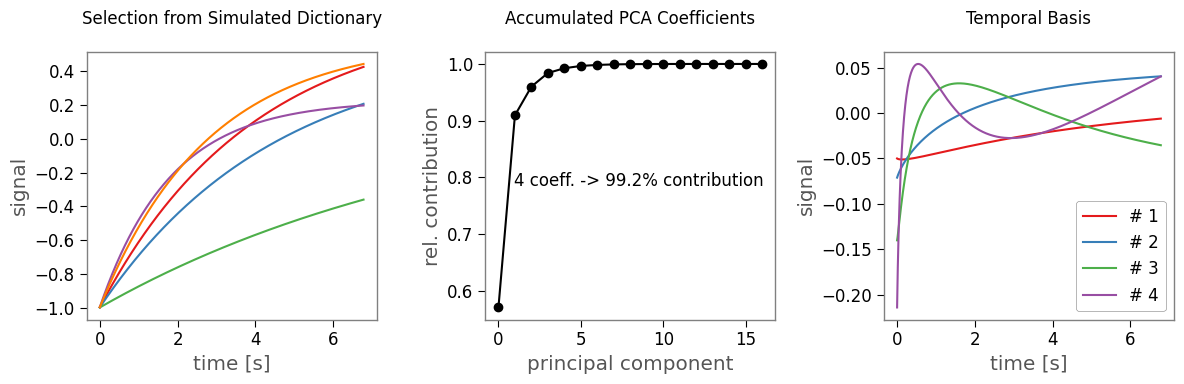

In [28]:
ps.plotSubspace()

In [29]:
%%pybash

# create the temporal basis
bart extract 1 0 {nCoe} U subbasis
# transpose the basis to have time on the 6th dimension and coefficients on the 5th dimension
bart transpose 1 6 subbasis - | bart transpose 0 5 - subbasis 

For consistency, check dimensions of subbasis, input data and trajectory:

In [30]:
%%bash 

head -n2 subbasis.hdr
head -n2 data/ksp_MID00019.hdr
head -n2 traj.hdr


# Dimensions
1 1 1 1 1 1131 4 1 1 1 1 1 1 1 1 1 
# Dimensions
1 512 1 18 1 1131 1 1 1 1 1 1 1 1 1 1 
# Dimensions
3 512 1 1 1 1131 1 1 1 1 1 1 1 1 1 1 


In [31]:
%%bash

DEBUG_LEVEL=4 bart ncalib -N -i16 -t traj -B subbasis data/ksp_MID00019 sens_ncalib

Est. image size: 256 256 1
ksp : [  1 512   1  18   1 1131   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 48  48   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 1131   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 512   1  18   1 1131   1   1   1   1   1   1   1   1   1   1 ]
images:     [ 48  48   1   1   1   1   4   1   1   1   1   1   1   1   1   1 ]
coils:      [ 16  16   1  18   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
basis:      [  1   1   1   1   1 1131   4   1   1   1   1   1   1   1   1   1 ]
mask:       [  1   1   1   1   1   1   1

In [32]:
ITER=100
REG=0.0005


In [33]:
%%pybash
# # reconstruction with subspace constraint
bart pics -g -e -d5 -i {ITER} -R W:$(bart bitmask 0 1):$(bart bitmask 6):{REG} -B subbasis -t traj data/ksp_MID00019 sens_ncalib subspace_reco

Basis: [256 256   1  18   1 1131   4   1   1   1   1   1   1   1   1   1 ]
Max:   [256 256   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
GPU reconstruction
[  1 512   1  18   1 1131   4   1   1   1   1   1   1   1   1   1 ]
[256 256   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512   1  18   1 1131   4   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 1131   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
psf_dims: [256 256   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1  16   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1   

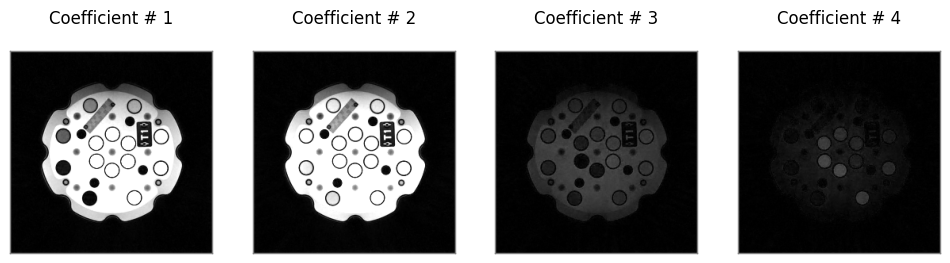

In [34]:
ps.plotCoefficientMaps()


In [35]:
%%bash
## coefficient map also suitable for mask 
bart slice 6 1 subspace_reco - | bart threshold -B 0.3 - mask
bart fmac mask subspace_reco subspace_reco

In [36]:
%%bash 
bart fmac -s $(bart bitmask 6) subbasis subspace_reco imgs

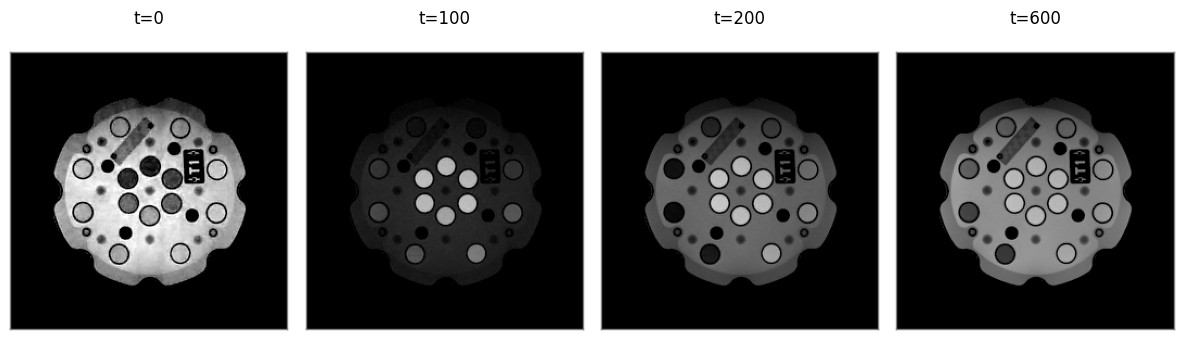

In [37]:
importlib.reload(ps)
ps.plotTemporalEvolution()


In [38]:
%%pybash
### create vector with inversion times nREP*TR
bart index 5 {REP} - | bart scale {TR} - TI

DEBUG_LEVEL=4 bart mobafit -g -i20 --init 1:1:1 -B subbasis -L TI subspace_reco - | bart looklocker -t0 -D15.3e-3 - t1map

Temp file for pipe: bart-aT5vlj
Step: 0, Res: 5748.667991
	 cg:  11
Step: 1, Res: 144.627954
	 cg:  10
Step: 2, Res: 274458.084239
	 cg:  50
Step: 3, Res: nan
	 cg:  50
Step: 4, Res: nan
	 cg:  50
Step: 5, Res: nan
	 cg:  50
Step: 6, Res: nan
	 cg:  50
Step: 7, Res: nan
	 cg:  50
Step: 8, Res: nan
	 cg:  50
Step: 9, Res: nan
	 cg:  50
Step: 10, Res: nan
	 cg:  50
Step: 11, Res: nan
	 cg:  50
Step: 12, Res: nan
	 cg:  50
Step: 13, Res: nan
	 cg:  50
Step: 14, Res: nan
	 cg:  50
Step: 15, Res: nan
	 cg:  50
Step: 16, Res: nan
	 cg:  50
Step: 17, Res: nan
	 cg:  50
Step: 18, Res: nan
	 cg:  50
Step: 19, Res: nan
	 cg:  50
Total Time: 2.49 s
Freed 3611607760 bytes.


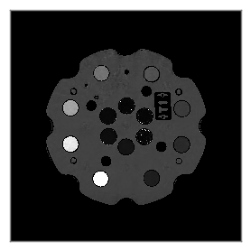

In [39]:
importlib.reload(ps)
ps.plotT1Map()